## Measuring a Spectral Line by $\chi^2$ fitting ##

In this tutorial you will measure the strength and width of a spectral line using frequentist $\chi^2$ fitting.

1) Read the data from the file line_data.csv into a pandas dataframe.  There are three 
columns: wavelength, flux and sigma.  Sigma is the known standard deviation 
of the flux in each pixel.  Plot the spectrum using matplotlib.pyplot.errorbar().

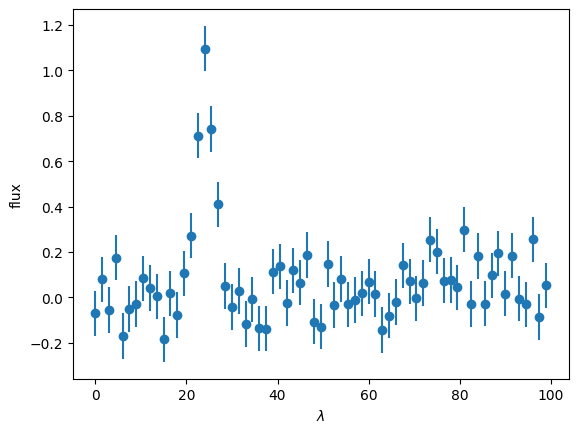

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pa

df = pa.read_csv('line_data.csv')
plt.errorbar(df['wavelength'],df['flux'], yerr=df['sigma'],fmt='o')
plt.xlabel(r'$\lambda$')
plt.ylabel('flux')
plt.show()

## rename some of the columns from the data frame
f = df['flux']
l = df['wavelength']
sigma = df['sigma']

We see that there appears to be a line around $\lambda \sim 23$.  We would like to find the center of this line and its width.

We will assume normally distributed errors in which case the $\chi^2$ is

$\chi^2 =  \sum_i \frac{[f_i - f_i(b,A,\lambda_o,\Delta\lambda) ]^2}{\sigma_i^2}$

where

$f_i(b,A,\lambda_o,\Delta\lambda) = A \exp\left[- \left( \frac{(\lambda_i - \lambda_o)}{\Delta\lambda }\right)^2 \right] + b$

There are four parameters in this model - the continuum, $b$, the amplitude of the line, $A$, the center of the line $\lambda_o$ and the width of the line, $\Delta\lambda$.  The continuum and amplitude are *linear* parameters while the others are *nonlinear* paramters.

2) First we will assume a $\lambda_o=23$ and $\Delta\lambda=2$ and find just the linear parameters.  This can be done analytically as shown in lecture.

First, we write a function that returns the line profile at an input wavelength given the parameters for the line shown above.

In [5]:
## Write a function for the line profile that takes 
## the wavelength,l, A, center of line, lo and the width 
## of the line dl
def line_profile(l,A,lo,dl):
    return A*np.exp(-((l-lo)/dl)**2)

Now we make a vector of fluxes at each of the wavelengths for the model line with $A=1$, $\lambda_o = 23$ and $\Delta\lambda = 2$.  This you could call a template for the line.

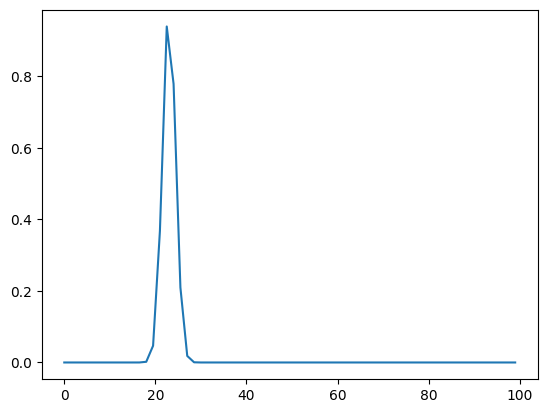

In [6]:
line = line_profile(l,1,23,2)

## lets take a look at it to make sure it is right
plt.plot(l,line)
plt.show()

We want to solve for the parameters that minimize the $\chi^2$.  This is closely related to the least squares problem that is more commonly implemented in python libraries.  To transform our problem into a least squares problem we need to scale the data and the $\pmb{M}$ matrix with the noise.  The $\pmb{M}$ matrix is defined as the matrix that takes a vector of parameter values and returns the predictions for the data points :

prediction vector = $\pmb{M}$ (parameter vector)

Below create a function that returns the parameters that minimize the $\chi^2$.

In [12]:
## function for finding the minimum chi-squared 
## with uncorrelated errors
def my_chi_squared(M,data,sigmas) :
    ## rescale data by standard diviations
    y = data/sigmas
    ## find the square root of the inverse of the covariance (hint: np.diag())
    sqrt_Cinv = np.sqrt(np.diag(1/sigmas))
    ## scale the M martrix 
    M = np.matmul(sqrt_Cinv**2,M)
    ## solve the least squares equation
    result = np.linalg.lstsq(M,y,rcond=None)
    
    ### return the best fit parameters and the 
    ### chi-squared for those parameters
    return result[0],result[1], result

Now we will construct the $\pmb{M}$ matrix that defines the linear model.  It will have a column of ones for the constant continuum and a column that is the line profile found above.

In [8]:
M = np.array([line , np.ones_like(line) ]).T
print(M.shape)

(67, 2)


Now we can find the best fit solution.

In [13]:
best_fit,chi_squared, results = my_chi_squared(M,f,sigma)
print('best fit solution :')
print('A : ', best_fit[0])
print('b : ', best_fit[1])
print('chi-squared : ',chi_squared)

best fit solution :
A :  1.0149137292507964
b :  0.04024046924187622
chi-squared :  [127.84195392]


Let us make a plot of this solution to see if it looks correct.

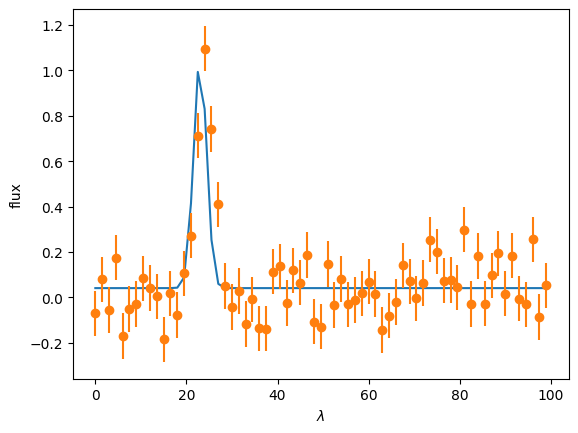

In [14]:
plt.plot(l,(results[0][0]*line + results[0][1]) )

plt.errorbar(df['wavelength'],df['flux'], yerr=df['sigma'],fmt='o')
plt.xlabel(r'$\lambda$')
plt.ylabel('flux')
plt.show()

How good a fit is this?  To find out we calculate the p-value for the $\chi^2$ distribution of $N-2$ degrees of freedom.

In [16]:
from scipy.stats import chi2

print('p-value = ', chi2.sf(chi_squared, len(f)-2))

p-value =  [5.42739762e-06]


Apparently it is not a good fit because the p-value is very small. It can be ruled out at a high confidence level.  

This is probably because we just guessed the $\lambda_o$ and $\Delta\lambda$ parameters.  We should fit them at the same time, but because they are nonlinear parameters we cannot find the best fit parameters analytically as for linear parameters.

But we can find the minimum $\chi^2$ numerically. First we must write a function that takes the parameters and returns the $\chi^2$.  It must be in a form that is acceptable for a library numerical minimizer.

In [22]:
def chi_squared_func(p):
    # the parameters are :
    # p[0] - A
    # p[1] - lambda_o - center of line
    # p[2] - D lambda - width of line
    # p[3] - b - continuum
    
    if(p[0] <= 0 or p[2] <= 0): # this is so that the minimizer will not go out of bounds
        return sys.float_info.max
    
    prediction = line_profile(l,p[0],p[1],p[2]) + p[3]
    
    return np.sum( ( ( f-prediction)/sigma )**2 )

In [23]:
import scipy.optimize as opt
import sys
## initial guess for parameter values
guess = np.array([1.0,23,2,0.01])
best_fit = opt.minimize(chi_squared_func,guess)

print('best fit model :')
print('          A = ',best_fit.x[0])
print('   lambda_o = ',best_fit.x[1])
print(' line width = ',best_fit.x[2])
print('  continuum = ',best_fit.x[3])
print('chi squared = ',best_fit.fun)

best fit model :
          A =  1.0286676822655234
   lambda_o =  24.117168549354123
 line width =  2.613981316006096
  continuum =  0.028616503009936674
chi squared =  75.3152561437631


Let us plot this best fit model and see if it looks better.

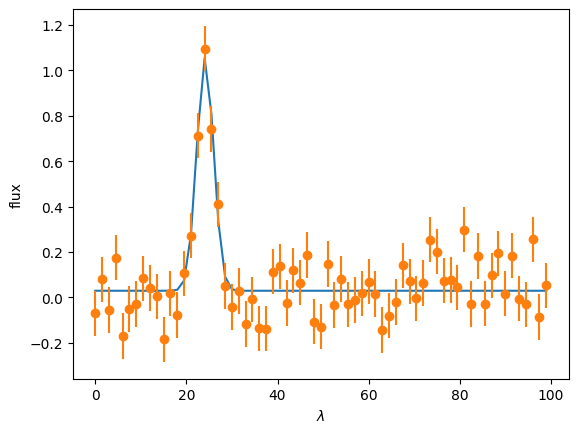

In [24]:
p = best_fit.x
prediction = line_profile(l,p[0],p[1],p[2]) + p[3]

plt.plot(l,prediction)
plt.errorbar(df['wavelength'],df['flux'], yerr=df['sigma'],fmt='o')
plt.xlabel(r'$\lambda$')
plt.ylabel('flux')
plt.show()

The best fit $\chi^2$ should be compared to a $\chi^2$ distribution with $N$ degrees of freedom, because we are not considering only linear parameters.  This is not a global fit statistic anymore, but only an indiction of whether the model with the best fit parameters is a good fit to the data.

In [26]:
print('p-value = ',chi2.sf(best_fit.fun, len(f)))

p-value =  0.22733457866264878


This p-value should look better.

Now lets make a two dimensional confidence level plot in $\lambda_o$-$\Delta\lambda$ space.  To do this we need to minimize $\chi^2$ for fixed values of $\lambda_o$ and $\Delta\lambda$.  Since the other paremeters are linear, this can be done easily using the functions we have already created.

/tmp/ipykernel_3864/1323283002.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi2map[i,j] = chi_squared_Ab(lo,dl)


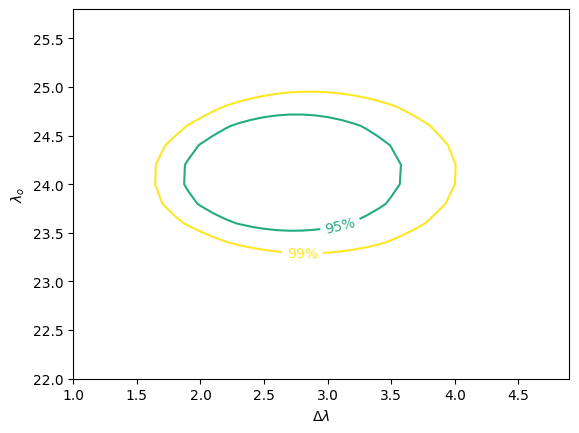

In [28]:


## write the chi-squared so that it takes only the lo and dl parameters 
## 
def chi_squared_Ab(lo,dl) :
    line = line_profile(l,1,lo,dl)
    M = np.array([line, np.ones_like(line) ]).T
    best_fit_Ab,chi_squared, results = my_chi_squared(M,f,sigma)
    
    return chi_squared


# array of widths
dls = np.arange(1,5,0.1)
# array of line centres
los = np.arange(22,26,0.2)

## make a map of chi2 over the ranges
chi2map = np.zeros([len(dls),len(los)])
i=0
for dl in dls :
    j=0
    for lo in los :
        #print(best_fit.x,best_fit.fun)
        chi2map[i,j] = chi_squared_Ab(lo,dl)
        j += 1
    i += 1

level99 = chi2.ppf(.99, len(f))
level95 = chi2.ppf(0.95, len(f))
level68 = chi2.ppf(0.68, len(f))

los,dls = np.meshgrid(los,dls)

fig, ax = plt.subplots()

CS = ax.contour(dls,los,chi2map,levels=[level68,level95,level99])

## the stupidly complicated way contours are labeled 
fmt = {}
strs = [ '68%', '95%', '99%']
for i,s in zip( CS.levels, strs ):
    fmt[i] = s

ax.clabel(CS, inline=True, fontsize=10,fmt=fmt)

plt.xlabel(r'$\Delta\lambda$')
plt.ylabel(r'$\lambda_o$')

#plt.imshow(chi2map)
plt.show()

In [29]:
print("minimum chi^2 : ",np.min(chi2map))
print("maximum chi^2 in range : ",np.max(chi2map))
print("chi^2 at 68% confidence level : ",level68)
print("chi^2 at 95% confidence level : ",level95)
print("chi^2 at 99% confidence level : ",level99)


minimum chi^2 :  75.55289598615444
maximum chi^2 in range :  243.7573160178938
chi^2 at 68% confidence level :  71.86374435065521
chi^2 at 95% confidence level :  87.10807219532191
chi^2 at 99% confidence level :  96.82781556371239
